# Loading human plays' data

In [1]:
import json
import pandas as pd
import numpy as np
import mmap
import json
import itertools
import seaborn as sns
import pylab as pl

In [2]:
# Load the json data
def load_jsonl(path: str, num_games: int = 30, mmap: bool = False, start_index = 0, completed_only: bool = False):
    '''
    Loads the jsonl data from the given path.
    If num_games is not -1, only the first num_games games are loaded.
    If mmap is True, the data is memory mapped.
    If completed_only is True, only completed games are loaded.
    '''
    games_jsons = []
    counter = 0
    with open(path, "r+b") as json_file:
        if mmap:
            with mmap.mmap(json_file.fileno(), length=0, access=mmap.ACCESS_READ) as mmap_object:
                for i, line in enumerate(iter(mmap_object.readline, b"")):
                    tmp = json.loads(line.decode("utf-8"))
                    if tmp["map"] == "standard":
                        if completed_only:
                            for phase in tmp["phases"]:
                                if phase["name"] == "COMPLETED":
                                    counter += 1
                                    if counter > start_index:
                                        games_jsons.append(tmp)
                        else:
                            counter += 1
                            if counter > start_index:
                                games_jsons.append(tmp)

                    if num_games != -1 and len(games_jsons) == num_games:
                        print("last game line is", i, counter)
                        break
        else:
            for i, line in enumerate(json_file):
                tmp = json.loads(line.decode("utf-8"))
                if tmp["map"] == "standard":
                    if completed_only:
                        for phase in tmp["phases"]:
                            if phase["name"] == "COMPLETED":
                                counter += 1
                                if counter > start_index:
                                    games_jsons.append(tmp)
                    else:
                        counter += 1
                        if counter > start_index:
                                games_jsons.append(tmp)

                if num_games != -1 and len(games_jsons) == num_games:
                    print("last game line is", i, counter)
                    break

    return games_jsons

In [5]:
start_index = 0
path = "../data/diplomacy-v1-27k-msgs/standard_no_press.jsonl"
games_jsons = load_jsonl(path, num_games=1000, mmap=False, start_index=start_index, completed_only=True)

last game line is 3734 1000


In [6]:
# Convert to a pandas dataframe
df = pd.DataFrame(games_jsons)

In [7]:
games = df['phases']

In [8]:
games.apply(lambda x: x[0])

0      {'name': 'S1901M', 'state': {'timestamp': 1542...
1      {'name': 'S1901M', 'state': {'timestamp': 1542...
2      {'name': 'S1901M', 'state': {'timestamp': 1542...
3      {'name': 'S1901M', 'state': {'timestamp': 1542...
4      {'name': 'S1901M', 'state': {'timestamp': 1542...
                             ...                        
995    {'name': 'S1901M', 'state': {'timestamp': 1542...
996    {'name': 'S1901M', 'state': {'timestamp': 1542...
997    {'name': 'S1901M', 'state': {'timestamp': 1542...
998    {'name': 'S1901M', 'state': {'timestamp': 1542...
999    {'name': 'S1901M', 'state': {'timestamp': 1542...
Name: phases, Length: 1000, dtype: object

In [9]:
for game in games:
    for ix, iy in enumerate(game):
        game[ix]['phase_id'] = ix

In [10]:
def flatten_json(input):
    out = {}
    out['game_id'] = input['state']['game_id']
    out['phase_id'] = input['phase_id']
    out['phase_name'] = input['name']
    results_units_keys = [x for x in input['results']]

    assert input['orders'].items() 
    for player, orders in input['orders'].items():
        if orders is not None:
            if orders:
                for order in orders:
                    out['coordinator'] = player
                    out['type'] = order.split()[0]
                    out['current_location'] = order.split()[1]
                    out['action'] = order.split()[2]
                    unit = order.split()[0]+ ' ' + order.split()[1]
                    # print("unit result is: ", unit , unit in results_units, results_units)
                    if input['results']:
                        # if the action is retreat, we have to check the units in the state to see if there are only one occurance available for the unit
                        # if out['action'] == 'R':
                        #     all_units = input['state']['units'].values()
                        #     if unit in all_units:
                        #         assert len(input['results'][unit]) == 0, "retreat should not have results"
                        #         out['result'] = ["void"]
                        out['results'] = input['results'][unit]
                    else:
                        print("empty results")
                        print(order)
                    out['impact_location'] = []
                    if out['action'] == '-' or out['action'] == 'R':
                        assert len(order.split()) == 4 or len(order.split()) == 5, order
                        out['impact_location'] = order.split()[3]
                    if unit in results_units_keys:
                        results_units_keys.remove(unit)
                    yield(out)
                
            else:
                # uncmomment these if you need a row for empty orders (in group by you will get 1 instead of 0)
                # out['coordinator'] = player
                # out['type'] = -1
                # out['current_location'] = -1
                # out['action'] = -1
                # out['results'] = -1
                # out['impact_location'] = -1
                # if out['action'] == '-' or out['action'] == 'R':
                #     assert len(order.split()) == 4 or len(order.split()) == 5, order
                #     out['impact_location'] = order.split()[3]
                # yield(out)
                pass

    if len(results_units_keys)>0:
        results_units_values = [input['results'][x] for x in results_units_keys]
        total_len = 0
        is_movement = True if out['phase_name'][-1] == 'M' else False
        for l in results_units_values:
                total_len += len(l)
        # if we are in the last movement phase, the results are not meaningful
        for unit in results_units_keys:
            if unit == 'WAIVE': ## FIXME: double check this later
                continue
            assert len(unit.split()) == 2, unit
            if not (total_len == 0 and is_movement):
                out['coordinator'] = 'RA'
            else:
                for player in input["state"]["units"]:
                    if unit in input["state"]["units"][player]:
                        out['coordinator'] = player

            if len(unit.split()[0]) != 1: # if we have sth like HOL D: "void"
                assert input['results'][unit][0] == 'void', input['results'][unit]
                location = unit.split()[0]
                assert unit.split()[1] == 'D', unit.split()[1]
                # find the corresponding key in the results
                for key in input['results']:
                    if key.split()[1] == location:
                        assert input['results'][key][0] == "disband", input['results'][key]
                        input['results'][key].append(input['results'][unit][0])
                        break
            else:
                out['type'] = unit.split()[0]
                out['current_location'] = unit.split()[1]
                out['results'] = input['results'][unit]
                if not (total_len == 0 and is_movement):
                    out['action'] = -2 # not in orders and only in result // only happens for 
                else:
                    out['action'] = -3
                out['impact_location'] = -2
                yield(out)

In [11]:
all_records = []
for idx, game in enumerate(games):
  for idx, phase in enumerate(game):
    row_generator = flatten_json(phase)
    assert row_generator is not None, row_generator
    for row in row_generator:
      all_records.append(row.copy())

In [12]:
complete_df = pd.DataFrame.from_records(all_records)

In [ ]:
complete_df.loc[complete_df['coordinator'] == 'RA']

In [ ]:
complete_df['unique_unit_id'] = -1

## Temporal Binding

In [13]:
def assign_unit_id(phase_df, source_unit_id_map, dest_unit_id_map, _id, discard_disband_creation=False):

    # fror each row in the phase df
    for idx, row in phase_df.iterrows():

        # if current location or type of army in invalid skip the row (we only deal with valid orders)
        if row['action'] == -1 or row['action'] == -2 or row['type'] == 'N':
            continue
        
        # get the current location of the unit
        source_unit = (row['type'] + ' ' + row['current_location'], row['coordinator'])

        # if the location is not in the map, add it to the map (in other phases the same unit can be used, hence checking the condition _ dictionaries are global, have data across phases)
        if source_unit not in source_unit_id_map:
            # if discard_disband_creation:
                # if row['action'] == 'D':
                #     print("disbanding a unit that does not exist", row)
                    # continue
            source_unit_id_map[source_unit] = _id
            _id += 1

        # destination dict is synced with source dict after the loop, so that we can use updated info at the beginning of each assignment
        phase_df.loc[idx,'unique_unit_id'] = source_unit_id_map[source_unit]

        if row['action'] == '-':
            result = row['results']
            if isinstance(result, list):
                if len(result) == 0:
                    try:
                        dest_unit = (row['type'] + ' ' + row['impact_location'], row['coordinator'])
                    except:
                        print("dest location error", row)
                        return
                    if dest_unit not in dest_unit_id_map:
                        dest_unit_id_map[dest_unit] = source_unit_id_map.pop(source_unit)
                elif 'disband' in result:
                    Exception("move with disband result")
                    # source_unit_id_map.pop(source_unit)
                    
        elif row['action'] == 'R':
            result = row['results']
            if isinstance(result, list):
                if len(result) == 0:
                    dest_unit = (row['type'] + ' ' + row['impact_location'], row['coordinator'])
                    if dest_unit not in dest_unit_id_map:
                        dest_unit_id_map[dest_unit] = source_unit_id_map.pop(source_unit)
                elif 'disband' in result:
                    if len(result) > 1:
                        if 'void' in result:
                                print(result)
                    source_unit_id_map.pop(source_unit)

        elif row['action'] == 'D':
            result = row['results']
            # if row.phase_id == 23:
            # print(result, "here")
            # print(result, type(result),isinstance(result, list), "no")
            assert source_unit in source_unit_id_map
            if isinstance(result, list):
                if len(result) == 0:
                    source_unit_id_map.pop(source_unit)
                    # del source_unit_id_map[source_unit]
                    # if row.phase_id == 23:
                    # print("popped it out")
                elif 'disband' in result:
                    source_unit_id_map.pop(source_unit)
                elif 'void' in result:
                    print("void disband", row)
            else:
                 print(result, type(result),isinstance(result, list), "yes")
        
        elif row['action'] == 'B':
            assert source_unit in source_unit_id_map

        elif row['action'] == 'H':
            assert source_unit in source_unit_id_map

        elif row['action'] == 'S':
            assert source_unit in source_unit_id_map
        
        elif row['action'] == 'C':
            assert source_unit in source_unit_id_map

        # for added result rows
        elif row['action'] == -2:
            pass
            # result = row['results']
            # assert source_unit in source_unit_id_map
            # if isinstance(result, list):
            #     if len(result) == 0:
            #         source_unit_id_map.pop(source_unit)
            #     # elif 'disband' in result and 'void' not in result:
            #     #     source_unit_id_map.pop(source_unit)
            #     # elif 'disband' in result and 'void' in result:
            #     #     source_unit_id_map.pop(source_unit)
            #     elif 'disband' in result:
            #         source_unit_id_map.pop(source_unit)
            #     else:
            #         print("unknown result", result)

        elif row['action'] == -3:
            assert source_unit in source_unit_id_map

        else:
            print("invalid action", row)

    # merge the source and destination dictionaries into one
    source_unit_id_map.update(dest_unit_id_map)
    # remove the destination dict (values get updated based on old data if we don't do this)
    dest_unit_id_map = {}

    return source_unit_id_map, dest_unit_id_map, _id

In [14]:
unique_games = complete_df["game_id"].unique()

In [ ]:
# unique_games = ['NxMelzPAbZMYgrHY']

In [15]:
def replace_dislodged_units(phases_cdf, dislodged_df):
    for idx, row in dislodged_df.iterrows():
        cond = phases_cdf["game_id"].apply(lambda x: x == row.game_id) & phases_cdf["type"].apply(lambda x: x == row.type) & phases_cdf["current_location"].apply(lambda x: x == row.current_location) & phases_cdf["phase_id"].apply(lambda x: x < row.phase_id) & phases_cdf["results"].apply(lambda x: 'dislodged' in x)
        assert phases_cdf.loc[cond].empty == False, (game_id, row)
        c = phases_cdf.loc[cond].iloc[-1]['coordinator']
        phases_cdf.loc[idx,'coordinator'] = c

In [16]:
game_phase_df_list = []
for idx, game_id in enumerate(unique_games):
    phases_df_list = []
    print(idx, game_id)
    s_dict = {}
    d_dict = {}
    _id = 1
    game_df = complete_df.loc[complete_df["game_id"].apply(lambda x: x == game_id)]
    unique_phases = game_df['phase_id'].unique()
    for phase in unique_phases:
        condition = game_df["phase_id"].apply(lambda x: x == phase)
        phase_df = game_df.loc[condition]
        s_dict, d_dict, _id = assign_unit_id(phase_df, s_dict, d_dict, _id, discard_disband_creation=False)
        # print(phase, s_dict)
        # print(d_dict)
        phases_df_list.append(phase_df)
    phases_cdf = pd.concat(phases_df_list)
    dislodged_df = phases_cdf.loc[phases_cdf['action'] == -2].copy()
    replace_dislodged_units(phases_cdf, dislodged_df)
    game_phase_df_list.append(phases_cdf)

0 rW_Q9TpidGLGD2EL


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


1 57xpw6Z-8IKo2hDK
2 sdKZrT-i_BvEZsFU
3 p6m8jMuDPsM0dtUh
4 0yv59hl6e5Ensb4M
5 NxMelzPAbZMYgrHY
6 omNMEctxL53gLSC0
7 h9QEPT6s5-Fi1WrV
8 HaJIleHsrwGvcRwO
9 BKJDUpmRsGnikiLG
10 8Vv4RupS6oaY3W9-
11 UUaNd1k82YhdM3Rh
12 E6sklWIxfto3V_J3
13 v08CT15R64vUdi9I
14 8QrJVtFLhrudJBbO
15 yCOKdNHDFvK7BDp8
16 EZl1DDW5twoaDS_C
17 144oP_8-6uqCHwZM
18 Szyr6ULvx7YrbDhE
19 5C84x0ZHALNdNKWU
20 HfXKaYlaJ-ps_Ya2
21 b6k2tC-e1mt1iffj
22 xj_kXXHeqDURjQEr
23 kDIaNZNUUXb_7mVg
24 4opSwJ0yKQvG6GUn
25 PwZbL4mKBdLnLOXD
26 uV-7w9KOVy_o2rdH
27 3yF7d9kILVlKwg4K
28 d_MnLiv2EBqiDtYS
29 MJMHyiWIXju2kUSI
30 A-J30ebaQMXpWz4A
31 bsDoJ5V3v3v49WN7
32 TPFTRCH2a15LeMxF
33 k28iYxWtOx1lWU11
34 MUzOMuSwyUDAvqTx
35 kEmjB7goNydF8Vye
36 _ezOXAmDjeWK7y2R
37 cnrI7fG4hFRzaejP
38 JofrQNQo1UdlEbiW
39 yJiy2DiDA2cVkAcW
40 8kFZ31Pm0f1Hvas_
41 CCMPrLeKxhOWwdZ0
42 5hoju_pTKyEgZmTN
43 vFV_wxRWxhijtFoZ
44 GR8M2f2FTWbhOuiY
45 LoiPYFIJZKP7ysev
46 VEQUkSbvIL1sTxTz
47 FM2prX411IWBjM6C
48 cKhQ4bNGlVav7tQK
49 HFOLo-v_5XJJZJpk
50 sPahEZFrbAYSS2pU
51 SrUGDo

397 0UHy04PfjSqSxhyP
398 gWhUu9krL72FpXkC
399 u5uMvjej4kTIyekR
400 86kHXyegoHgAH9Cz
401 jDMPHh0OmXjoxiuu
402 27OYqfP6UmJN5ZdQ
403 e6Y6vlmvwF87ij8c
404 1pr1epSMRH4LDEUx
405 5q2VwO6_eXlKwr_6
406 WXD0XJKV7xVrlas2
407 9uDak0Od5pQI_GFY
408 4HoxGNwngo0jF4rW
409 YfYrasosU6-_bgWU
410 Lc6brjERSsIH52Fn
411 KL0QTF19nszxevEC
412 SP3Hje4l2gxkbnlL
413 zuFsuVMeuiDtoNDr
414 E-SK8z7BnssptCOa
415 lMm2ZR-7dU2gVB-X
416 3Yvp4TwbDwENd5uA
417 X5bA592so6_1-bj9
418 B7gYnpCETIEGOpsI
419 1j5hULBywTwptWWR
420 4vsZ8m_2bTHAvx6a
421 Lk0ijKTvD_GAfW3l
422 5XYFBRohYmCo3HA8
423 uE3p_LujKUaUSQFU
424 akdsuxJW8BorgsGy
425 JJTcA4ta0PPEKFZ2
426 _Tyxj5fCPHiJ0KFJ
427 UDCXzk-3OjlwZrMf
428 ohCQZ0EM3k_7iGdm
429 uTzJOYi7C46zxBkE
430 bbg6dSwrpaGiz5jT
431 oSsWjfRO6wL6fMQn
432 QP-uXX2HAhIi8a4T
433 _K8aUkLVsfSrRfMj
434 uAfnMgdvCJdnnaXO
435 9CB1e47Xq3pG8u1a
436 3InJZ8Vx1G8N3gua
437 e5NIRwUNfxDLdjgs
438 dyg4SKZoCB-XcMRG
439 dt0sUdEc4InqxdU0
440 63bAfyH9_Zl129Sz
441 mTpvf6FnIaQzXRbU
442 z1d3CZSuX6kW7fxm
443 VgsCNs8xSJ5clSzt
444 x6F4Tr7zG

788 O0i3mrp6AEW_Z_Oe
789 ohCp0d8G0SeSCEwP
790 gb8_kHu466KjXSFX
791 QArlAfK1P5gPdJv3
792 TTWndJUbVVPs1wrL
793 UR_rHV-0pUQVufoP
794 QWwIyC2Gf8ePkXrw
795 riROrqm5K4sUTwDQ
796 hsq59ypY5zwdSnuT
797 xhx-D44x0i_OapVi
798 uNJ9kvkISuL0n3AX
799 NaZQI9JaCsllh_S1
800 oLoJO4JGiMEQQYst
801 8Gj4sjY7ZKxLINYB
802 M9R8FapDvEZWjnPv
803 ftp1r-Pk_ioq-rEn
804 xNKn_8Q_uxHNKoC3
805 Y7LK6TtcXeAGwgqA
806 sdtbyfwYhf8vYxYT
807 PRDBfMCuesI6Ef54
808 h6yYdEGVERy3QBcm
809 AeajdK2qoZcIiBbP
810 YvlV2-iexzyZPZnC
811 587ueVXAkOCLIxJh
812 4xHzQ8fJRTfJfaTM
813 svgQ0NH8Z-yyZB_t
814 7xuahHV3PswHNQZ5
815 ziSsnHYJ_v-Kc-07
816 fulv3y-6EAtZfdfF
817 Sk-FtFRNw9tenF7c
818 8Htxzk0awreoJ3KK
819 1oE8L3ATWHAALF_M
820 AIatqXhaEPwJy8Va
821 3fLJo9f1-3Ursv7D
822 V5tL9Z9YgCV3sRo7
823 xQNCWWBdTz80sVHY
824 avd2PsIG6W1vX9iS
825 VELizklTIVfKH00U
826 scgbFlcEunek9LmP
827 l00cGloYazO60cPt
828 o0kybAIPSZYAkH6E
829 2JZgyluGaouz-5Tq
830 iioZXbulGY5wwS7Z
831 cTtW9F7O-grkrPO9
832 k4znFt3mCfzdzErt
833 vjJZZCMI2kulHrgt
834 BJzUFz7tguzcfVz_
835 soSPEymWl

In [17]:
# cdf = pd.concat(game_phase_df_list, ignore_index=True)
cdf = pd.concat(game_phase_df_list)

In [ ]:
cdf

In [ ]:
assert cdf.loc[cdf['coordinator'] == 'RA'].empty

In [ ]:
cdf.loc[cdf['action'] == -3]

In [ ]:
complete_df.loc[complete_df['coordinator'] == 'RA']

## Check the concatenated df

reduce to only 2 seasons per year

In [18]:
spring_fall_phases=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R') & (cdf['phase_name'].apply(lambda x:x[-1]) == 'M')
cdf_sf = cdf.loc[spring_fall_phases].copy()
cdf_sf['phase_num']=cdf_sf.phase_name.apply(lambda x: float(x[1:-1]+('.0' if x[0]=='S' else '.5')))

compute a binary winner label

In [19]:
winner_series=pd.Series(index=cdf.game_id.unique())
for game_id in winner_series.index:
    tmax=cdf_sf.loc[cdf_sf.game_id==game_id].phase_num.max()
    final_units=cdf_sf.loc[(cdf_sf.game_id==game_id) & (cdf_sf.phase_num==tmax)].groupby('coordinator').unique_unit_id.nunique()
    winner_series[game_id]=final_units.idxmax() if len(final_units)>0 else np.nan
def dummy(row,winner_series):
    return row.coordinator==winner_series[row.game_id]
from functools import partial
part_dummy=partial(dummy,winner_series=winner_series)
cdf_sf['winner']=cdf_sf.apply(part_dummy,axis=1)

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


view winning stats

In [20]:
winner_series.value_counts()

TURKEY     235
FRANCE     171
GERMANY    159
ENGLAND    122
RUSSIA     117
ITALY       99
AUSTRIA     97
dtype: int64

compute winner loser plot

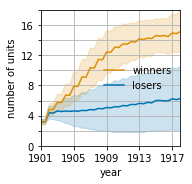

In [23]:
unitcounts=cdf_sf.groupby(["game_id","coordinator","phase_num","winner"])["unique_unit_id"].nunique()
# winlose_data.groupby(['winner','phase_name']).mean().unstack().T.plot(legend=False,xticks=np.arange(1900,1920,5))
fig,ax=pl.subplots(1,1,figsize=(2.5,2.5))#ensemble statistics
sns.lineplot(ax=ax,
             x='phase_num',
             y='unique_unit_id',
             data=unitcounts.reset_index().drop(labels=['game_id','coordinator'],axis=1),
             hue=r'winner',
             ci='sd',
             palette=sns.color_palette("colorblind", 2))
h,l=ax.get_legend_handles_labels()
ax.legend(handles=h[1:][::-1],labels=['winners','losers'],frameon=False)
ax.grid()
ax.set_yticks(np.arange(0,20,2))
ax.set_yticklabels([0,'',4,'',8,'',12,'',16,''])
ax.set_xticks(np.arange(1901,1919,4))
ax.set_ylabel('number of units')
ax.set_xlabel('year')
ax.set_ylim(0,18)
ax.set_xlim(1901,1918)
fig.savefig('winners_and_losers_1000.pdf',format='pdf',dpi=300,bbox_inches='tight')

### Exploring Data for different games

In [ ]:
complete_df.loc[complete_df["game_id"] == 'uXFQ2zgI-DUrgwlS']['phase_id'].unique()

In [ ]:
cdf.loc[cdf['coordinator'] == 'RA'][:40].sort_values(by=['phase_id', 'unique_unit_id'])

In [ ]:
unique_games

In [ ]:
spring_fall_phases=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R') & (cdf['phase_name'].apply(lambda x:x[-1]) == 'M')
cdf[spring_fall_phases].groupby(["game_id","coordinator","phase_name"])["unique_unit_id"].nunique().unstack().T.plot()

In [ ]:
cdf[spring_fall_phases].groupby(["game_id","coordinator","phase_name"])["unique_unit_id"].nunique().unstack().head(14)
cdf.groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

In [ ]:
cnd=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R') & (cdf['game_id'].apply(lambda x: x == '0yv59hl6e5Ensb4M') )
cdf[cnd].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(7)

In [ ]:
cdf[spring_fall_phases].loc[cdf["game_id"] == "0yv59hl6e5Ensb4M"]

## Save a single game to JSON 

In [ ]:
from pprint import pprint
import json

In [ ]:
game_id = "NxMelzPAbZMYgrHY"
for game in games_jsons:
    if game['id'] == game_id:
        json.dump(game, open(f'{game_id}.json', 'w'))

# Calculate different triples

### Manual exploration

In [ ]:
# for a single game:
game_id = "lVp6PZxk3Jpufc9Z"
game_df = cdf.loc[cdf["game_id"] == game_id]

In [ ]:
spring_fall_phases = (game_df['phase_name'].apply(lambda x:x[-1]) == 'M')
game_df = game_df.loc[spring_fall_phases]

In [ ]:
game_df["phase_num"] = game_df.phase_name.apply(lambda x: float(x[1:-1]+('.0' if x[0]=='S' else '.5')))

In [ ]:
game_df["unique_unit_id"].nunique()

In [ ]:
game_df["unique_unit_id"].max()

In [ ]:
game_df.loc[game_df["unique_unit_id"].idxmax()]

In [ ]:
players = game_df["coordinator"].unique()
assert len(players) == 7

In [ ]:
player_units = {}
for player in players:
    player_units[player] = game_df.loc[game_df["coordinator"] == player]["unique_unit_id"].unique()

In [ ]:
#https://stackoverflow.com/questions/45655936/how-to-test-all-items-of-a-list-are-disjoint
# make sure some units are handed over to other players

import itertools
def all_disjoint(iterables):
    merged = itertools.chain(*iterables)
    total = list(merged)
    total.sort()
    print(total)
    print(set(total))
    return len(total) == len(set(total))

In [ ]:
all_units = list(player_units.values())

In [ ]:
all_disjoint(all_units)

In [ ]:
player_units

In [ ]:
unique_two_players = set(itertools.permutations(player_units.keys(), 2))

In [ ]:
len(unique_two_players)

In [ ]:
from collections import namedtuple
Triple = namedtuple('Triple', ['triple', 'player_i', 'player_j'])

In [ ]:
triples = []
for player_i, player_j in unique_two_players:
    p_units = list(itertools.combinations(player_units[player_i], 2))
    o_unit = list(itertools.combinations(player_units[player_j], 1))
    # get all 3-tuples unique combinations
    p_o_product = list(itertools.product(p_units, o_unit))
    p_o_product = [(a, b, c) for (a,b), (c,) in p_o_product]
    # triple = [Triple(t, player_i, player_j) for t in p_o_product]
    triple = [dict(triple=t, player_i=player_i, player_j=player_j) for t in p_o_product]
    triples.extend(triple)
    # first tuple in the product belongs to player_i and the other belongs to player_j
        # break

In [ ]:
len(triples)

In [ ]:
for triple in triples:
    print(triple)
    condition_i = (game_df["unique_unit_id"].apply(lambda x: x in triple['triple'][:2])) & (game_df["coordinator"].apply(lambda x: x == triple['player_i']))
    condition_j = (game_df["unique_unit_id"].apply(lambda x: x in triple['triple'][2:])) & (game_df["coordinator"].apply(lambda x: x == triple['player_j']))
    presence = game_df.loc[condition_i | condition_j]
    break

In [ ]:
presence.sort_values(['unique_unit_id'])

In [ ]:
phases = presence["phase_name"].value_counts()

In [ ]:
mask = (phases == 3).to_dict()

In [ ]:
mask

In [ ]:
eligible_phases = presence.loc[presence["phase_name"].apply(lambda x: mask[x])]

In [ ]:
sorted_unqiue__eligible_phases = eligible_phases.phase_num.unique()
sorted_unqiue__eligible_phases.sort()

In [ ]:
sorted_unqiue__eligible_phases

In [ ]:
eligible_phases.phase_num.min()

### Sanity check that the code works

In [ ]:
def get_triples(game_df):
    players = game_df["coordinator"].unique()
    assert len(players) == 7, players
    player_units = {}
    for player in players:
        player_units[player] = game_df.loc[game_df["coordinator"] == player]["unique_unit_id"].unique()
    
    triples = []
    unique_two_players = set(itertools.permutations(player_units.keys(), 2))
    for player_i, player_j in unique_two_players:
        p_units = list(itertools.combinations(player_units[player_i], 2))
        o_unit = list(itertools.combinations(player_units[player_j], 1))
        # get all 3-tuples unique combinations
        p_o_product = list(itertools.product(p_units, o_unit))
        p_o_product = [(int(a), int(b), int(c)) for (a,b), (c,) in p_o_product]
        triple = [dict(triple=t, player_i=player_i, player_j=player_j) for t in p_o_product]
        triples.extend(triple)
    return triples

In [ ]:
def get_triples_presence(game_df, triples):
    empty_eligible_phaes = 0
    for triple in triples:
        condition_i = (game_df["unique_unit_id"].apply(lambda x: x in triple['triple'][:2])) & (game_df["coordinator"].apply(lambda x: x == triple['player_i']))
        condition_j = (game_df["unique_unit_id"].apply(lambda x: x in triple['triple'][2:])) & (game_df["coordinator"].apply(lambda x: x == triple['player_j']))
        presence = game_df.loc[condition_i | condition_j]
        phases = presence["phase_name"].value_counts()
        mask = (phases == 3).to_dict()
        eligible_phases = presence.loc[presence["phase_name"].apply(lambda x: mask[x])]
        unqiue_eligible_phases = eligible_phases.phase_num.unique()
        max_phase_num = eligible_phases.phase_num.max()
        min_phase_num = eligible_phases.phase_num.min()
        max_min_diff = max_phase_num - min_phase_num
        if len(unqiue_eligible_phases):
            assert (max_min_diff/0.5 + 1) == len(unqiue_eligible_phases) , ("values are not contiguous", len(unqiue_eligible_phases), unqiue_eligible_phases, max_min_diff, game_df["game_id"].unique(), triple)
        else:
            empty_eligible_phaes += 1
        triple['max_phase_num'] = float(max_phase_num)
        triple['min_phase_num'] = float(min_phase_num)
        triple['max_min_diff'] = float(max_min_diff)
    return empty_eligible_phaes

In [ ]:
game_tiple_presence = {}
for game_id in unique_games:
    assert type(game_id) is str, (game_id, "is not a string")
    print(game_id)
    game_df = cdf_sf.loc[cdf_sf['game_id'] == game_id]
    if game_df.unique_unit_id.nunique() == game_df.unique_unit_id.max():
        triples = get_triples(game_df)
        try:
            emp = get_triples_presence(game_df, triples)
            print(emp, len(triples))
            game_tiple_presence[game_id] = triples
        except AssertionError as msg:
            print(msg)

In [ ]:
import json
with open(f'game_tiple_presence_{start_index}.json', 'w') as file:          
    json.dump(game_tiple_presence, file, indent=4, sort_keys=True,)

In [ ]:
game_dfs = []
for game_id in unique_games:
    game_df = cdf_sf.loc[cdf_sf['game_id'] == game_id]
    game_dfs.append(game_df)

In [30]:
import json
with open(f'../data/game_tiple_presence_100.json', 'r') as file:          
    jj = json.load(file)
    print(jj.keys())

dict_keys(['0ttJkNSnC1NDzzsi', '0yv59hl6e5Ensb4M', '144oP_8-6uqCHwZM', '1p-WXKrqrCfvH8mY', '3yF7d9kILVlKwg4K', '4BZT_H2gwHIhj6YS', '57xpw6Z-8IKo2hDK', '5C84x0ZHALNdNKWU', '5hoju_pTKyEgZmTN', '8NM2MaXEw9NCtb7D', '8QrJVtFLhrudJBbO', '8Vv4RupS6oaY3W9-', '8eeN-aIcPIYfWoed', '8kFZ31Pm0f1Hvas_', '9yrnQcPLPcNI-zEY', 'A-J30ebaQMXpWz4A', 'BKJDUpmRsGnikiLG', 'C75O2TDDQrePH2W5', 'D5lBQEoVwBZpyqtf', 'DF6m8MkzJQrZ-lXj', 'DQzCrp2wkcFuRa01', 'E6sklWIxfto3V_J3', 'EZl1DDW5twoaDS_C', 'Eg9Q3yTXBuXvq7DU', 'F7EocxbPdlSSZBCp', 'FM2prX411IWBjM6C', 'FYYVuB2E7_vqnqVe', 'GR6jM3i94NHVUvLe', 'GR8M2f2FTWbhOuiY', 'H4Il79WA5T4ckTaT', 'HFOLo-v_5XJJZJpk', 'HfXKaYlaJ-ps_Ya2', 'JofrQNQo1UdlEbiW', 'LJdW8X5cL7jVfBHZ', 'LoiPYFIJZKP7ysev', 'MJMHyiWIXju2kUSI', 'MKkZcmc5yit0GPa-', 'MUzOMuSwyUDAvqTx', 'MiGWPJruAPXAL6wY', 'O-W_pcGosuZjgHm6', 'OYTWZZRGXYBE_eoh', 'P7mlY1g3BkglHt-s', 'Pe3y60SDlzPSRHy_', 'PkCccP4eK5LaIxAg', 'PwZbL4mKBdLnLOXD', 'SHZbjtO3GfxS8qfT', 'Szyr6ULvx7YrbDhE', 'TPFTRCH2a15LeMxF', 'UUaNd1k82YhdM3Rh', 'VEQUkSbv

In [47]:
triple_id=0
game_id=list(jj.keys())[triple_id]
jj[game_id][triple_id]

{'max_min_diff': 1.0,
 'max_phase_num': 1902.0,
 'min_phase_num': 1901.0,
 'player_i': 'ENGLAND',
 'player_j': 'AUSTRIA',
 'triple': [4, 5, 1]}

In [57]:
cdf_sf.action.unique()

array(['-', 'H', 'S', 'C', -3], dtype=object)

In [155]:
triple_id=0
game_id=list(jj.keys())[triple_id]
triple=jj[game_id][triple_id]
seq=cdf_sf[(cdf_sf.game_id==game_id) 
    & (cdf_sf.coordinator.isin([triple['player_i'],triple['player_j']]))
    & (cdf_sf.unique_unit_id.isin(triple['triple'])) 
    & (cdf_sf.phase_num.isin(np.arange(triple['min_phase_num'],triple['max_phase_num'],0.5)))].loc[:,('coordinator','unique_unit_id','phase_num','action')]

In [ ]:
#if use actions as is then skip this cell, else define the actions:
#def dummy(row):
#    return row.action if row.action=='H' else row.current_location+' '+row.impact_location
#seq.action=seq.apply(dummy,axis=1)

In [153]:
datatmp=seq.groupby(['unique_unit_id','phase_num'])['action'].aggregate('first').unstack()
datatmp

phase_num,1901.0,1901.5
unique_unit_id,,
1,H,H
4,H,-
5,H,-


In [152]:
same_pair_inds=[0,1]
diff_pair_inds=[0,2]

In [164]:
#do the 5 unique counting operations
unit_counts=datatmp.nunique(axis=1)
same_pair_inds=[0,1]
diff_pair_inds=[0,2]
joint_counts=[len(datatmp.loc[np.asarray(triple['triple'])[same_pair_inds]].T.drop_duplicates()),
              len(datatmp.loc[np.asarray(triple['triple'])[diff_pair_inds]].T.drop_duplicates())]

In [ ]:
#apply unique in each of 3 rows (n1,n2,n3) and then twice over columns, once over each of the two pairs of rows (n4,n5)
same=unit_counts[same_pair_inds]/joint_counts[0]
different=unit_counts[diff_pair_inds]/joint_counts[1]

In [173]:
#collect into a loop
# same_pair_inds=[0,1]
# diff_pair_inds=[0,2]
# for game_id,di in jj.items():
samediff_count_list=[]
di=jj[game_id]
game_df=cdf_sf[(cdf_sf.game_id==game_id)]
for triple_id,triple in enumerate(di):
    if triple['max_min_diff']>0:
        seq=game_df[(game_df.coordinator.isin([triple['player_i'],triple['player_j']])) 
            & (game_df.unique_unit_id.isin(triple['triple'])) 
            & (game_df.phase_num.isin(np.arange(triple['min_phase_num'],triple['max_phase_num'],0.5)))].loc[:,('coordinator','unique_unit_id','phase_num','action')]

        datatmp=seq.groupby(['unique_unit_id','phase_num'])['action'].aggregate('first').unstack()
        unit_counts=datatmp.nunique(axis=1)
        tridat=np.asarray(triple['triple'])
        joint_counts=[len(datatmp.loc[np.asarray(triple['triple'])[same_pair_inds]].T.drop_duplicates()), \
                      len(datatmp.loc[np.asarray(triple['triple'])[diff_pair_inds]].T.drop_duplicates())]
        factor_same=np.prod(unit_counts[tridat[same_pair_inds]].values)/joint_counts[0]
        factor_different=np.prod(unit_counts.loc[tridat[diff_pair_inds]].values)/joint_counts[1]
        samediff_count_list.append((factor_same,factor_different))
    else:
        samediff_count_list.append(None)

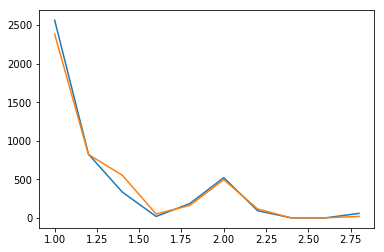

In [188]:
fig,ax=pl.subplots()
for data in zip(*filter(None,samediff_count_list)):
    counts,bins=np.histogram(data)
    ax.plot(bins[:-1],counts)

## Debug

In [ ]:
game_df = cdf_sf.loc[cdf_sf['game_id'] == "NxMelzPAbZMYgrHY"]

In [ ]:
game_df_2 = cdf.loc[cdf['game_id'] == "NxMelzPAbZMYgrHY"]

In [ ]:
game_df.loc[game_df["phase_num"] == 1906.5]

In [ ]:
game_df_2.loc[game_df_2["unique_unit_id"] == 8]

In [ ]:
game_df.loc[game_df["phase_id"] == 23]

In [ ]:
game_df_2.loc[game_df_2["phase_id"] == 23]

# Loading Deepmind's Diplomacy trajectory

In [ ]:
action_outputs = np.load(file='../data/actions_outputs.npz', allow_pickle=True)

In [ ]:
action_outputs[1][0]

In [ ]:
pd.DataFrame.from_dict(action_outputs[0][0]).corr(method='pearson')

In [ ]:
legal_actions = np.load(file='../data/legal_actions.npz', allow_pickle=True)

In [ ]:
len(legal_actions)

In [ ]:
legal_actions[0].shape

In [ ]:
observations = np.load(file='../data/observations.npz', allow_pickle=True)

In [ ]:
len(observations)

In [ ]:
observations[1]

In [ ]:
step_outputs = np.load(file='../data/step_outputs.npz', allow_pickle=True)

In [ ]:
len(step_outputs)

In [ ]:
step_outputs[0]